# Introduction: Implémentez un modèle de scoring

La société financière, "Prêt à dépenser", propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).


# Data

Les données sont disponibles à ce lien : https://www.kaggle.com/c/home-credit-default-risk/data

## Imports

In [71]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow

import joblib

## Read in Data 

In [73]:
# List files available
print(os.listdir("data/"))

['application_test.csv', '.DS_Store', 'application_train.csv']


In [74]:
# Training data
app_train = pd.read_csv('data/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
app_test = pd.read_csv('data/application_test.csv')

In [76]:
app_test.shape

(48744, 121)

In [40]:
ID = app_train[["SK_ID_CURR"]]

In [41]:
y = app_train[["TARGET"]]

In [65]:
app_test_dtypes_dict = app_test.dtypes.to_dict()
app_test_dtypes_dict
#app_test.astype(app_test_dtypes_dict)

{'SK_ID_CURR': dtype('int64'),
 'NAME_CONTRACT_TYPE': dtype('O'),
 'CODE_GENDER': dtype('O'),
 'FLAG_OWN_CAR': dtype('O'),
 'FLAG_OWN_REALTY': dtype('O'),
 'CNT_CHILDREN': dtype('int64'),
 'AMT_INCOME_TOTAL': dtype('float64'),
 'AMT_CREDIT': dtype('float64'),
 'AMT_ANNUITY': dtype('float64'),
 'AMT_GOODS_PRICE': dtype('float64'),
 'NAME_TYPE_SUITE': dtype('O'),
 'NAME_INCOME_TYPE': dtype('O'),
 'NAME_EDUCATION_TYPE': dtype('O'),
 'NAME_FAMILY_STATUS': dtype('O'),
 'NAME_HOUSING_TYPE': dtype('O'),
 'REGION_POPULATION_RELATIVE': dtype('float64'),
 'DAYS_BIRTH': dtype('int64'),
 'DAYS_EMPLOYED': dtype('int64'),
 'DAYS_REGISTRATION': dtype('float64'),
 'DAYS_ID_PUBLISH': dtype('int64'),
 'OWN_CAR_AGE': dtype('float64'),
 'FLAG_MOBIL': dtype('int64'),
 'FLAG_EMP_PHONE': dtype('int64'),
 'FLAG_WORK_PHONE': dtype('int64'),
 'FLAG_CONT_MOBILE': dtype('int64'),
 'FLAG_PHONE': dtype('int64'),
 'FLAG_EMAIL': dtype('int64'),
 'OCCUPATION_TYPE': dtype('O'),
 'CNT_FAM_MEMBERS': dtype('float64'),
 'R

# Exploratory Data Analysis

## Examine the Distribution of the Target Column

La target est la valeur que l'on veut prédire: 0 le crédit sera payé à temps et 1 signifie un défaut de paiement.

In [42]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<AxesSubplot:ylabel='SK_ID_CURR'>

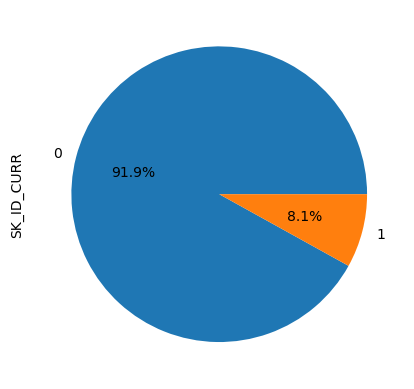

In [43]:
data = app_train.groupby("TARGET")["SK_ID_CURR"].sum()
data.plot.pie(autopct="%.1f%%")

<AxesSubplot:ylabel='Frequency'>

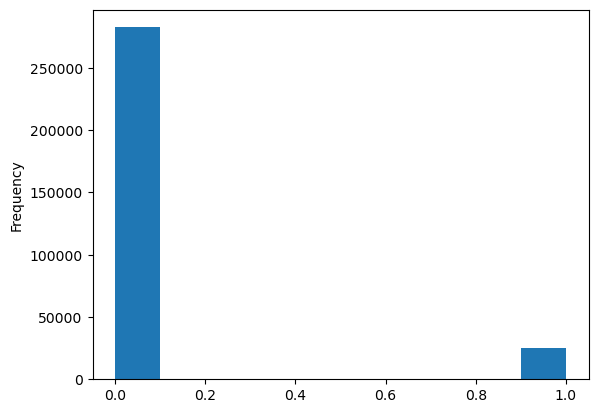

In [9]:
app_train['TARGET'].astype(int).plot.hist()

On peut voir un problème de déséquilibre de classe entre le nombre de bons et de moins bons clients. Il y a beaucoup plus de bons clients que de moins bons clients.

## Examine Missing Values

In [77]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [78]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


## Imputation 

In [79]:
app_train_imput = app_train.iloc[:,2:]

In [80]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent', 
                        missing_values=np.nan)

imputer = imputer.fit(app_train_imput)

app_train.iloc[:,2:] = imputer.transform(app_train_imput)

app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
import joblib

joblib.dump(imputer, 'imputer.pkl')

['imputer.pkl']

In [84]:
missing_values = missing_values_table(app_train)
missing_values.head()

Your selected dataframe has 122 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## Column Types

`int64` and `float64` sont des variables numériques. 
`object` sont des variables catégoriques.

In [85]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [86]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables! 

## Encoding Categorical Variables

Before we go any further, we need to deal with pesky categorical variables.  A machine learning model unfortunately cannot deal with categorical variables (except for some models such as [LightGBM](http://lightgbm.readthedocs.io/en/latest/Features.html)). Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process:

* Label encoding: assign each unique category in a categorical variable with an integer. No new columns are created. An example is shown below

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/label_encoding.png)

* One-hot encoding: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns. 

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/one_hot_encoding.png)

The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. In the example above, programmer recieves a 4 and data scientist a 1, but if we did the same process again, the labels could be reversed or completely different. The actual assignment of the integers is arbitrary. Therefore, when we perform label encoding, the model might use the relative value of the feature (for example programmer = 4 and data scientist = 1) to assign weights which is not what we want. If we only have two unique values for a categorical variable (such as Male/Female), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the safe option.

There is some debate about the relative merits of these approaches, and some models can deal with label encoded categorical variables with no issues. [Here is a good Stack Overflow discussion](https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor). I think (and this is just a personal opinion) for categorical variables with many classes, one-hot encoding is the safest approach because it does not impose arbitrary values to categories. The only downside to one-hot encoding is that the number of features (dimensions of the data) can explode with categorical variables with many categories. To deal with this, we can perform one-hot encoding followed by [PCA](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf) or other [dimensionality reduction methods](https://www.analyticsvidhya.com/blog/2015/07/dimension-reduction-methods/) to reduce the number of dimensions (while still trying to preserve information). 

In this notebook, we will use Label Encoding for any categorical variables with only 2 categories and One-Hot Encoding for any categorical variables with more than 2 categories. This process may need to change as we get further into the project, but for now, we will see where this gets us. (We will also not use any dimensionality reduction in this notebook but will explore in future iterations).

### Label Encoding and One-Hot Encoding

Let's implement the policy described above: for any categorical variable (`dtype == object`) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding. 

For label encoding, we use the Scikit-Learn `LabelEncoder` and for one-hot encoding, the `OneHotEncoder` function.

In [87]:
dic_le = {}

In [88]:
import copy

In [89]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0
col_le = []

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform training data
            app_train[col] = le.transform(app_train[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
            dic_le[col] = copy.copy(le)
            
            
            
            #col_le.append(col)
            
print('%d columns were label encoded.' % le_count)

#nom des colonnes => nom des fichiers => 16 modèles
#dico qui associe à chq nom de colonne => l'encodeur => 1 modèle. dico vide : ajout d'élement, valeur : modele (enc ou le)
#joblib.dump du dico 



4 columns were label encoded.


In [90]:
dic_le

{'NAME_CONTRACT_TYPE': LabelEncoder(),
 'FLAG_OWN_CAR': LabelEncoder(),
 'FLAG_OWN_REALTY': LabelEncoder(),
 'EMERGENCYSTATE_MODE': LabelEncoder()}

In [91]:
list_ohe = list(app_train.select_dtypes(include=['object']).columns) 

In [92]:
list_ohe

['CODE_GENDER',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE']

In [93]:
#list_ohe_test = ['CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OWN_CAR_AGE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']

In [95]:
#set(list_ohe).intersection(set(list_ohe_test))

In [96]:
#set(list_ohe_test) - set(list_ohe)  #valeurs ds le test

In [97]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(app_train[list_ohe])
ohe = enc.transform(app_train[list_ohe])
ohe_df = pd.DataFrame(ohe.todense(), columns=enc.get_feature_names_out().tolist())
app_train = pd.concat([app_train, ohe_df], axis=1)



print('%d columns were one hot encoded.' % len(list_ohe))

12 columns were one hot encoded.


In [98]:
app_train.drop(app_train.dtypes[app_train.dtypes == 'object'].index.tolist(), inplace=True, axis=1)

In [99]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [100]:
print('Training Features shape: ', app_train.shape)

Training Features shape:  (307511, 242)


In [101]:
joblib.dump(dic_le, 'dic_le.pkl')
joblib.dump(enc, 'enc_ohe.pkl')

['enc_ohe.pkl']

## Back to Exploratory Data Analysis

### Anomalies

One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the `describe` method. The numbers in the `DAYS_BIRTH` column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:



In [25]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment? 

In [26]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

That doesn't look right! The maximum value (besides being positive) is about 1000 years! 

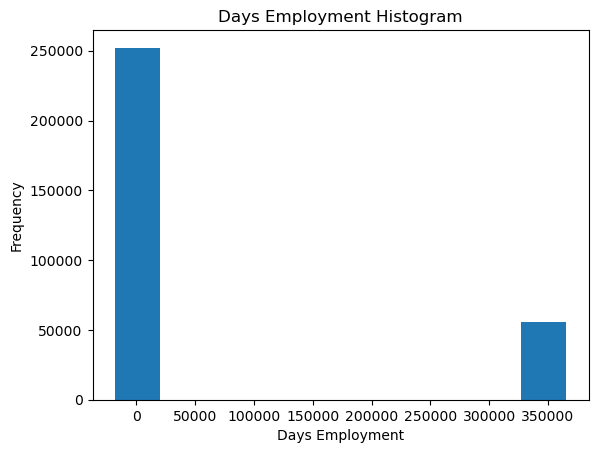

In [27]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Just out of curiousity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [28]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Well that is extremely interesting! It turns out that the anomalies have a lower rate of default. 

Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number (`np.nan`) and then create a new boolean column indicating whether or not the value was anomalous.



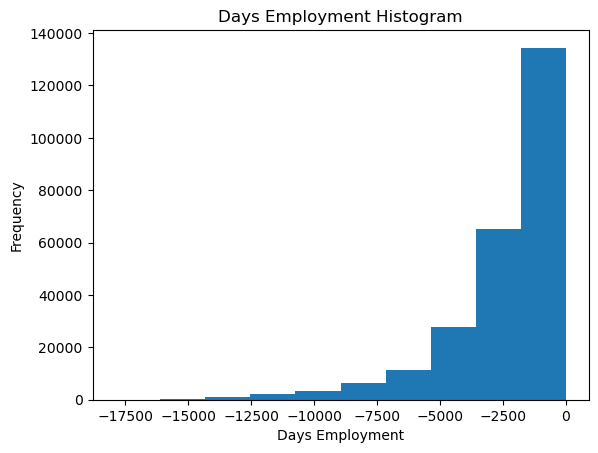

In [102]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

The distribution looks to be much more in line with what we would expect, and we also have created a new column to tell the model that these values were originally anomalous (becuase we will have to fill in the nans with some value, probably the median of the column). The other columns with `DAYS` in the dataframe look to be about what we expect with no obvious outliers. 

In [103]:
app_train_imput2 = app_train.iloc[:,2:]

imputer = imputer.fit(app_train_imput2)

app_train.iloc[:,2:] = imputer.transform(app_train_imput2)

app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,DAYS_EMPLOYED_ANOM
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False


In [73]:
#imputer = imputer.fit(app_train)

#app_train.iloc[:,:] = imputer.transform(app_train)

#app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,DAYS_EMPLOYED_ANOM
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False


In [104]:
joblib.dump(imputer, 'imputer2.pkl')

['imputer2.pkl']

### Correlations

Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the `.corr` dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some [general interpretations of the absolute value of the correlation coefficent](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf) are:


* .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
* .80-1.0 “very strong”


In [23]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DAYS_REGISTRATION                                    0.041975
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
DAYS_EMPLOYED                                        0.048199
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055217
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Let's take a look at some of more significant correlations: the `DAYS_BIRTH` is the most positive correlation. (except for `TARGET` because the correlation of a variable with itself is always 1!) Looking at the documentation, `DAYS_BIRTH` is the age in days of the client at the time of the loan in negative days (for whatever reason!). The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.

### Effect of Age on Repayment

In [22]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982712

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often. 

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.

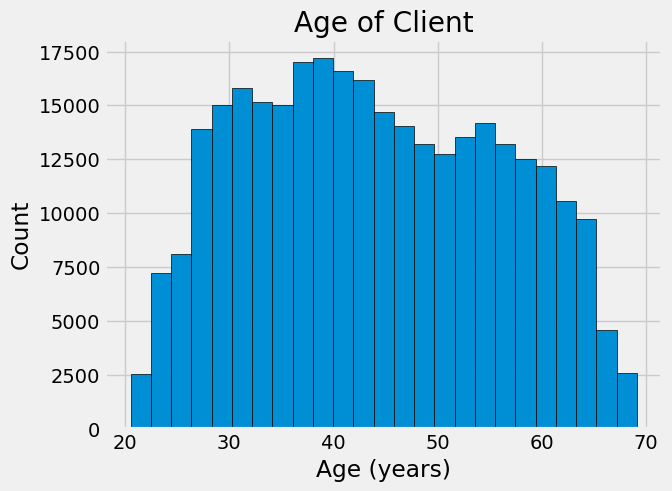

In [25]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a [kernel density estimation plot](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) colored by the value of the target. A [kernel density estimate plot shows the distribution of a single variable](https://chemicalstatistician.wordpress.com/2013/06/09/exploratory-data-analysis-kernel-density-estimation-in-r-on-ozone-pollution-data-in-new-york-and-ozonopolis/) and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn `kdeplot` for this graph.

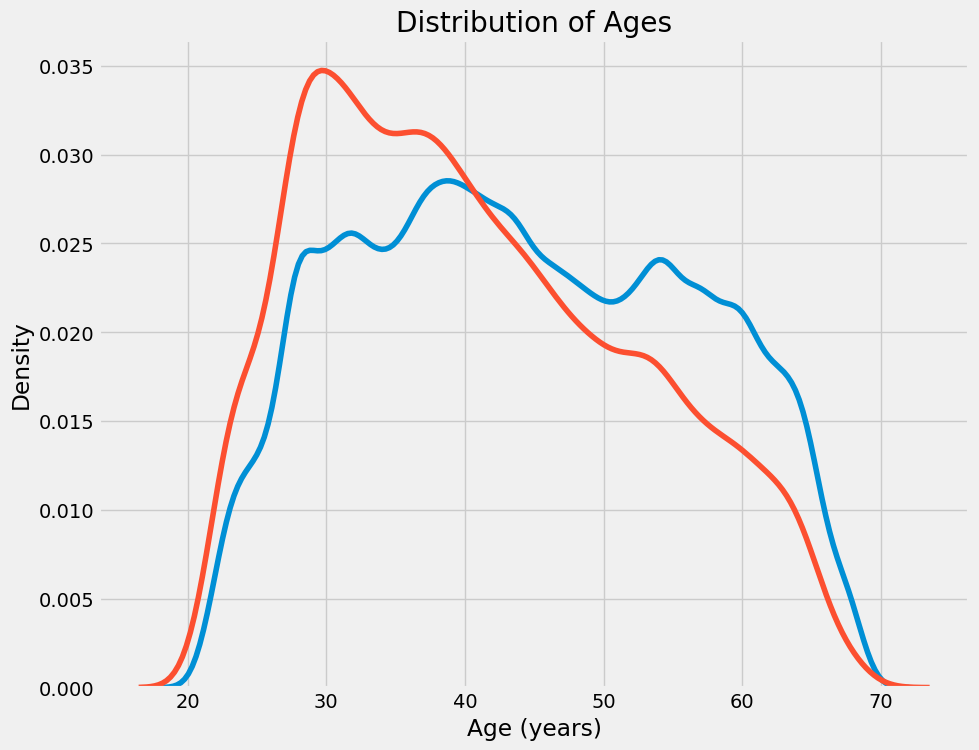

In [26]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket. 

To make this graph, first we `cut` the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [23]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [49]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


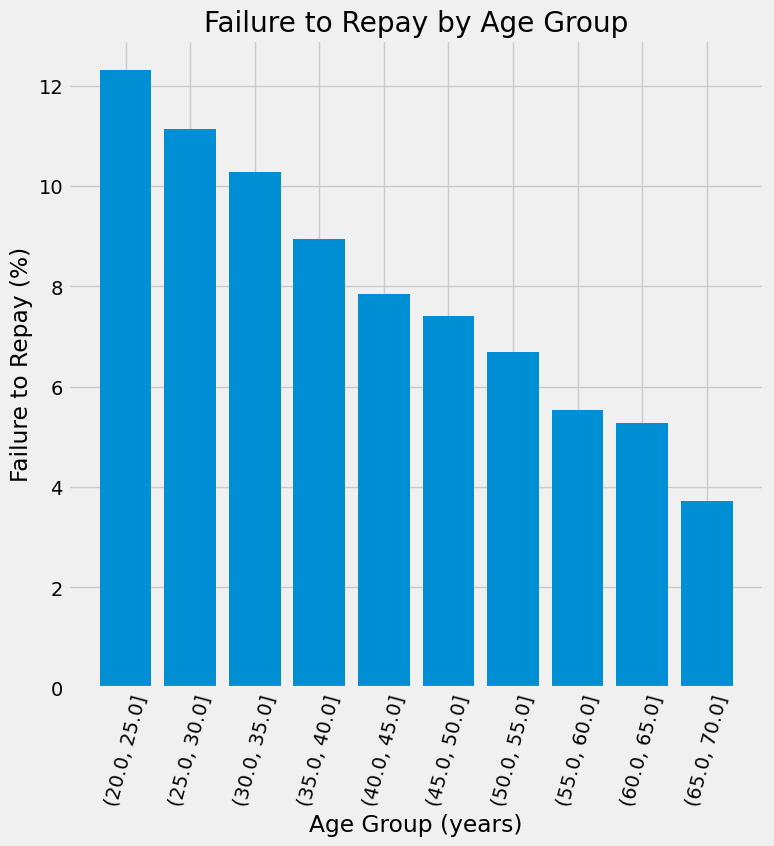

In [50]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

### Exterior Sources

The 3 variables with the strongest negative correlations with the target are `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`.
According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data. 

Let's take a look at these variables.

First, we can show the correlations of the `EXT_SOURCE` features with the target and with each other.

In [51]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.096599,-0.160039,-0.127891,-0.078239
EXT_SOURCE_1,-0.096599,1.000000,0.145527,0.038738,0.194669
EXT_SOURCE_2,-0.160039,0.145527,1.000000,0.063254,0.091435
EXT_SOURCE_3,-0.127891,0.038738,0.063254,1.000000,0.138837
DAYS_BIRTH,-0.078239,0.194669,0.091435,0.138837,1.000000


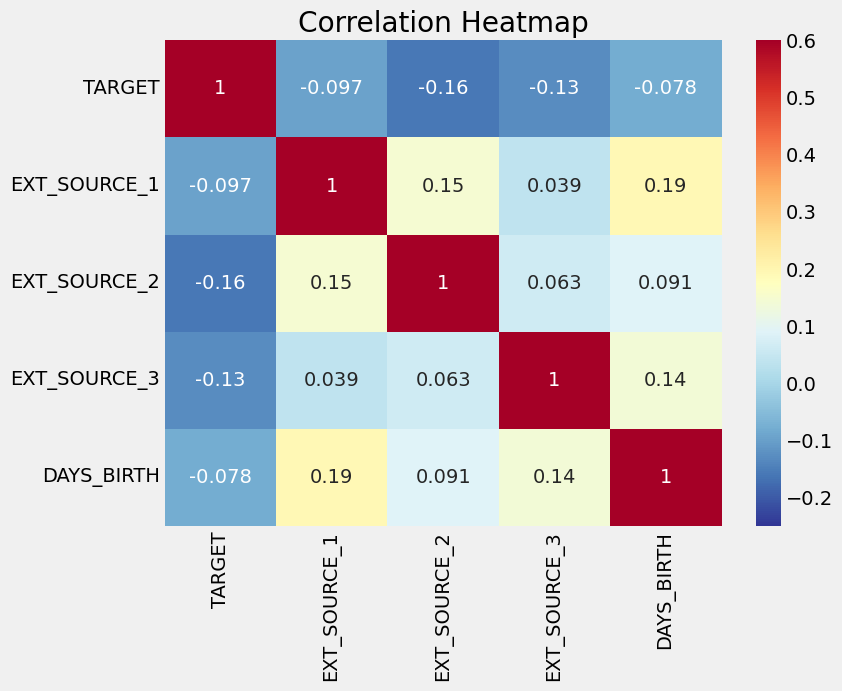

In [52]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

All three `EXT_SOURCE` featureshave negative correlations with the target, indicating that as the value of the `EXT_SOURCE` increases, the client is more likely to repay the loan. We can also see that `DAYS_BIRTH` is positively correlated with `EXT_SOURCE_1` indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

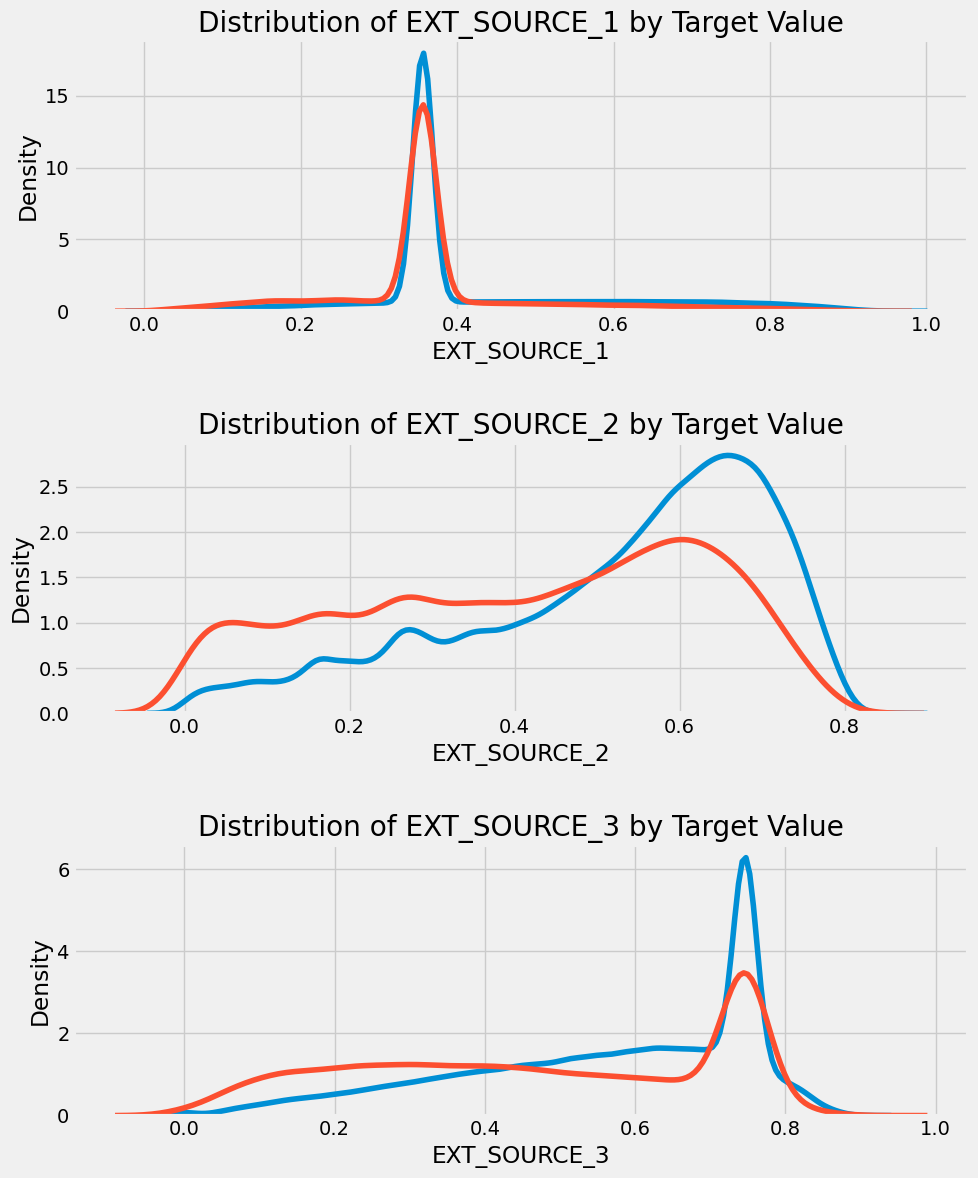

In [53]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

`EXT_SOURCE_3` displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all [considered very weak](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf), but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

## Pairs Plot

As a final exploratory plot, we can make a pairs plot of the `EXT_SOURCE` variables and the `DAYS_BIRTH` variable. The [Pairs Plot](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166) is a great exploration tool because it lets us see relationships between multiple pairs of variables as well as distributions of single variables. Here we are using the seaborn visualization library and the PairGrid function to create a Pairs Plot with scatterplots on the upper triangle, histograms on the diagonal, and 2D kernel density plots and correlation coefficients on the lower triangle.

If you don't understand this code, that's all right! Plotting in Python can be overly complex, and for anything beyond the simplest graphs, I usually find an existing implementation and adapt the code (don't repeat yourself)! 

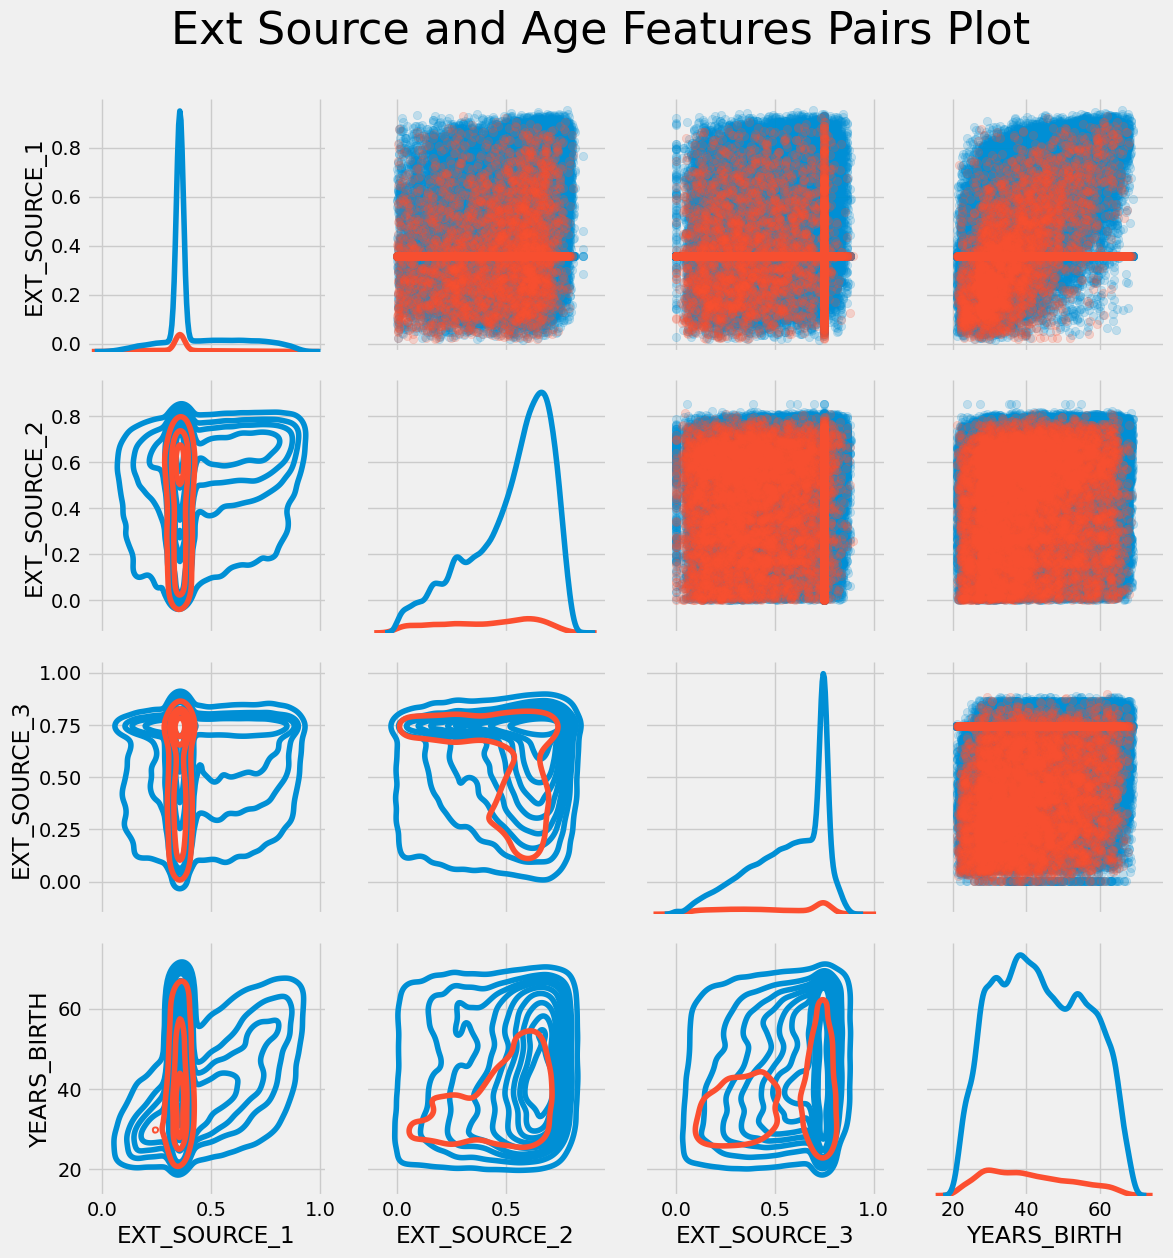

In [54]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

In this plot, the red indicates loans that were not repaid and the blue are loans that are paid. We can see the different relationships within the data. There does appear to be a moderate positive linear relationship between the `EXT_SOURCE_1` and the `DAYS_BIRTH` (or equivalently `YEARS_BIRTH`), indicating that this feature may take into account the age of the client. 

# Train Test

In [55]:
mlflow.tracking.get_tracking_uri() #suivi des enregistrements s'exécute dans un répertoire mlruns

'file:///Users/swearit/Documents/Alternance/P7_Kalic_Adeline_022023/mlruns'

In [26]:
X = app_train.iloc[:,2:]

In [27]:
X.describe()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
count,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.095213,0.340108,0.693673,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,16036.995067,...,0.007466,0.005785,0.005284,0.214757,0.210773,0.017437,0.508408,0.518446,0.007570,0.473983
std,0.293509,0.473746,0.460968,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,...,0.086085,0.075840,0.072501,0.410654,0.407858,0.130892,0.499930,0.499660,0.086679,0.499323
min,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,7489.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,12413.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,15750.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,19682.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,25229.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [77]:
y = app_train.iloc[:,1]

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Réduction de la base d'apprentissage à 20% 

In [60]:
X_poub, X_train_reduc, y_poub, y_train_reduc = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

## Feature Scaling

In [61]:
from sklearn.preprocessing import MinMaxScaler

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))


# Repeat with the scaler
scaler.fit(X_train_reduc)
X_train_reduc = scaler.transform(X_train_reduc)
X_test = scaler.transform(X_test)

print('Training data shape: ', X_train_reduc.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (49202, 241)
Testing data shape:  (61503, 241)


## DummyClassifier

In [41]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [63]:
df = pd.DataFrame()

In [64]:
def score(y_test, y_proba, model_name, df, treshold, time, best_param): #rajouter seuil en paramètre
    
    roc_auc_sc = roc_auc_score(y_test, y_proba)
    
    y_pred = (y_proba > treshold).real
    
    prec_score = precision_score(y_test, y_pred)
    rec_score = recall_score(y_test, y_pred)
    f1_sc = f1_score(y_test, y_pred)
    
    scores = pd.concat([df, (pd.DataFrame([model_name, best_param, prec_score, rec_score, f1_sc, roc_auc_sc, time],
                 index=['model_name', 'best_param', 'precision', 'recall', 'f1', 'roc_auc', 'time'])).T])
    
    return scores

In [65]:
import time

In [66]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_reduc, y_train_reduc)

t_start = time.time()

y_proba = dummy_clf.predict_proba(X_test)

end = time.time()

seconds = round(end - t_start, 2)

print(seconds)

0.01


In [67]:
df = score(y_test, y_proba[:, 1], model_name = 'DummyClassifier', df = df, treshold = 0.5, 
           time = seconds, best_param = None)

In [68]:
df

,model_name,best_param,precision,recall,f1,roc_auc,time
0,DummyClassifier,None,0.0,0.0,0.0,0.5,0.01


The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The best value is 1 and the worst value is 0.

The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 * (precision * recall) / (precision + recall)

## Logistic Regression

In [69]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"], "solver":['liblinear']}# l1 lasso l2 ridge

logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(X_train_reduc,y_train_reduc)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}


In [70]:
print(logreg_cv.best_estimator_.predict_proba(X_test))

[[0.90073413 0.09926587]
 [0.89610381 0.10389619]
 [0.90012041 0.09987959]
 ...
 [0.90025551 0.09974449]
 [0.8899605  0.1100395 ]
 [0.89821132 0.10178868]]


In [71]:
t_start = time.time()

y_proba = logreg_cv.best_estimator_.predict_proba(X_test)

end = time.time()

seconds = round(end - t_start, 2)

In [72]:
df = score(y_test, y_proba[:, 1], model_name = 'LogisticRegression', df = df, treshold = 0.5, 
          time = seconds, best_param = logreg_cv.best_params_)

In [73]:
df

,model_name,best_param,precision,recall,f1,roc_auc,time
0,DummyClassifier,None,0.0,0.0,0.0,0.5,0.01
0,LogisticRegression,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.0,0.0,0.0,0.66795,0.03


## Decision Tree

In [74]:
from sklearn.tree import DecisionTreeClassifier

In [75]:
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(1, 15)}

In [76]:
dt_cv = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv= 5)
dt_cv.fit(X_train_reduc, y_train_reduc)

print("tuned hpyerparameters :(best parameters) ",dt_cv.best_params_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 1}


In [77]:
t_start = time.time()

y_proba = dt_cv.best_estimator_.predict_proba(X_test)

end = time.time()

seconds = round(end - t_start, 2)

In [78]:
df = score(y_test, y_proba[:, 1], model_name = 'DecisionTreeClassifier', df = df, treshold = 0.5,
     time = seconds, best_param = dt_cv.best_params_)

In [79]:
df

,model_name,best_param,precision,recall,f1,roc_auc,time
0,DummyClassifier,None,0.0,0.0,0.0,0.5,0.01
0,LogisticRegression,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.0,0.0,0.0,0.66795,0.03
0,DecisionTreeClassifier,"{'criterion': 'gini', 'max_depth': 1}",0.0,0.0,0.0,0.602592,0.08


## RandomForestClassifier

In [80]:
grid = { 
    'n_estimators': [100],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : range(10,36,5),
    'criterion' :['gini', 'entropy']
}

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_cv = RandomizedSearchCV(RandomForestClassifier(), grid, n_iter=5, n_jobs=-1)
rf_cv.fit(X_train_reduc, y_train_reduc)

print("tuned hpyerparameters :(best parameters) ",rf_cv.best_params_)

t_start = time.time()

y_proba = rf_cv.best_estimator_.predict_proba(X_test)

end = time.time()

seconds = round(end - t_start, 2)

print(seconds)

tuned hpyerparameters :(best parameters)  {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}
1.16


In [82]:
df = score(y_test, y_proba[:, 1], model_name = 'RandomForestClassifier', df = df, treshold = 0.5,
     time = seconds, best_param = rf_cv.best_params_)

## Lightgbm (séquentiel)

In [83]:
import lightgbm as lgb

lgb=lgb.LGBMClassifier()
#Define the parameters
parameters = {'max_depth':[-1,5,10,20],
             'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]}

#Define the scoring
clf=GridSearchCV(lgb,parameters)
clf.fit(X_train_reduc, y=y_train_reduc)
print(clf.best_params_)

t_start = time.time()

y_proba = clf.best_estimator_.predict_proba(X_test)

end = time.time()

seconds = round(end - t_start, 2)

{'learning_rate': 0.05, 'max_depth': -1, 'reg_alpha': 0}


In [84]:
df = score(y_test, y_proba[:, 1], model_name = 'LGBMClassifier', df = df, treshold = 0.5,
     time = seconds, best_param = clf.best_params_)

In [85]:
df

,model_name,best_param,precision,recall,f1,roc_auc,time
0,DummyClassifier,None,0.0,0.0,0.0,0.5,0.01
0,LogisticRegression,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.0,0.0,0.0,0.66795,0.03
0,DecisionTreeClassifier,"{'criterion': 'gini', 'max_depth': 1}",0.0,0.0,0.0,0.602592,0.08
0,RandomForestClassifier,"{'n_estimators': 100, 'max_features': 'sqrt', ...",0.0,0.0,0.0,0.72359,1.16
0,LGBMClassifier,"{'learning_rate': 0.05, 'max_depth': -1, 'reg_...",0.456311,0.009497,0.018606,0.748696,0.53


## ML Flow tracking

In [86]:
def get_performances(X_tr, y_tr, X_te, y_te, model):
    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)

    pre_tr = precision_score(y_tr, y_tr_pred)
    pre_te = precision_score(y_te, y_te_pred)

    rec_tr = recall_score(y_tr, y_tr_pred)
    rec_te = recall_score(y_te, y_te_pred)

    f1_tr = f1_score(y_tr, y_tr_pred)
    f1_te = f1_score(y_te, y_te_pred)

    y_tr_prob = model.predict_proba(X_tr)[:,1]
    y_te_prob = model.predict_proba(X_te)[:,1]

    auc_tr = roc_auc_score(y_tr, y_tr_prob)
    auc_te = roc_auc_score(y_te, y_te_prob)

    perf_metrics = {
        'pre_tr': pre_tr,
        'pre_te': pre_te,
        'rec_tr': rec_tr,
        'rec_te': rec_te,
        'f1_tr': f1_tr,
        'f1_te': f1_te,
        'auc_tr': auc_tr,
        'auc_te': auc_te
    }

    return perf_metrics

In [87]:
from mlflow.models.signature import infer_signature

# Setting an experiment for automatic logging
mlflow.set_experiment(experiment_name="ML_without_classweight")

# Checking if the script is executed directly
if __name__ == "__main__":
    
    # Starting a logging run
    with mlflow.start_run(run_name="DummyClassifier") as run:
        # Fitting GridSearchCV
        model = dummy_clf
        dummy_clf.fit(X_train_reduc, y_train_reduc)
        signature = infer_signature(X_train_reduc, model.predict_proba(X_train_reduc))
        perf_metrics = get_performances(X_train_reduc, y_train_reduc, X_test, y_test, model)
        mlflow.log_metrics(perf_metrics)
        
    with mlflow.start_run(run_name="LogisticRegression") as run:
        # Fitting GridSearchCV
        model = logreg_cv
        logreg_cv.fit(X_train_reduc,y_train_reduc)
        signature = infer_signature(X_train_reduc, model.predict_proba(X_train_reduc))
        mlflow.log_params(logreg_cv.best_params_)
        perf_metrics = get_performances(X_train_reduc, y_train_reduc, X_test, y_test, model)
        mlflow.log_metrics(perf_metrics)
        
    with mlflow.start_run(run_name="DecisionTreeClassifier") as run:
        # Fitting GridSearchCV
        model = dt_cv
        dt_cv.fit(X_train_reduc, y_train_reduc)
        signature = infer_signature(X_train_reduc, model.predict_proba(X_train_reduc))
        mlflow.log_params(dt_cv.best_params_)
        perf_metrics = get_performances(X_train_reduc, y_train_reduc, X_test, y_test, model)
        mlflow.log_metrics(perf_metrics)
        
    with mlflow.start_run(run_name="RandomForestClassifier") as run:
        # Fitting GridSearchCV
        model = rf_cv
        rf_cv.fit(X_train_reduc, y_train_reduc)
        signature = infer_signature(X_train_reduc, model.predict_proba(X_train_reduc))
        mlflow.log_params(rf_cv.best_params_)
        perf_metrics = get_performances(X_train_reduc, y_train_reduc, X_test, y_test, model)
        mlflow.log_metrics(perf_metrics)

    with mlflow.start_run(run_name="LGBMClassifier") as run:
        # Fitting GridSearchCV
        model = clf
        clf.fit(X_train_reduc, y=y_train_reduc)
        signature = infer_signature(X_train_reduc, model.predict_proba(X_train_reduc))
        mlflow.log_params(clf.best_params_)
        perf_metrics = get_performances(X_train_reduc, y_train_reduc, X_test, y_test, model)
        mlflow.log_metrics(perf_metrics)
              

# with class weights

## Logistic Regression

In [88]:
df_cw = pd.DataFrame()

In [89]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

logredgrid={"C":np.logspace(-3,3,7), "penalty":["l2"], "solver":['lbfgs'], 
     "max_iter":[250]}# l1 lasso l2 ridge
#d'autres solver
logreg2=LogisticRegression(class_weight='balanced')
logreg_cv=GridSearchCV(logreg2,logredgrid,cv=5, n_jobs=-1)
logreg_cv.fit(X_train_reduc,y_train_reduc)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)

/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'max_iter': 250, 'penalty': 'l2', 'solver': 'lbfgs'}


In [90]:
#barplot F1 

In [91]:
print(logreg_cv.best_estimator_.predict_proba(X_test))

[[0.32788691 0.67211309]
 [0.72653625 0.27346375]
 [0.38082036 0.61917964]
 ...
 [0.67268343 0.32731657]
 [0.41813624 0.58186376]
 [0.64819274 0.35180726]]


In [92]:
t_start = time.time()

y_proba = logreg_cv.best_estimator_.predict_proba(X_test)

end = time.time()

seconds = round(end - t_start, 2)

In [93]:
df_cw = score(y_test, y_proba[:, 1], model_name = 'LogisticRegression', df = df_cw, treshold = 0.5, 
          time = seconds, best_param = logreg_cv.best_params_)

In [94]:
df_cw

,model_name,best_param,precision,recall,f1,roc_auc,time
0,LogisticRegression,"{'C': 0.1, 'max_iter': 250, 'penalty': 'l2', '...",0.154454,0.663568,0.250582,0.735833,0.03


## Decision Tree

In [95]:
from sklearn.tree import DecisionTreeClassifier

In [96]:
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(1, 15)}

In [97]:
dt_cv = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'), param_grid=param_grid, 
                     cv= 5, n_jobs=-1)
dt_cv.fit(X_train_reduc, y_train_reduc)

print("tuned hpyerparameters :(best parameters) ",dt_cv.best_params_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 1}


In [98]:
t_start = time.time()

y_proba = dt_cv.best_estimator_.predict_proba(X_test)

end = time.time()

seconds = round(end - t_start, 2)

In [99]:
df_cw = score(y_test, y_proba[:, 1], model_name = 'DecisionTreeClassifier', df = df_cw, treshold = 0.5,
     time = seconds, best_param = dt_cv.best_params_)

In [100]:
df_cw

,model_name,best_param,precision,recall,f1,roc_auc,time
0,LogisticRegression,"{'C': 0.1, 'max_iter': 250, 'penalty': 'l2', '...",0.154454,0.663568,0.250582,0.735833,0.03
0,DecisionTreeClassifier,"{'criterion': 'gini', 'max_depth': 1}",0.136148,0.497878,0.213824,0.610717,0.1


## RandomForestClassifier

In [101]:
grid = { 
    'n_estimators': [100],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : range(10,36,5),
    'criterion' :['gini', 'entropy']
}

In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_cv = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced'), grid, n_iter=5, n_jobs=-1)
rf_cv.fit(X_train_reduc, y_train_reduc)

print("tuned hpyerparameters :(best parameters) ",rf_cv.best_params_)

t_start = time.time()

y_proba = rf_cv.best_estimator_.predict_proba(X_test)

end = time.time()

seconds = round(end - t_start, 2)

print(seconds)

tuned hpyerparameters :(best parameters)  {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 35, 'criterion': 'entropy'}
2.1


In [103]:
df_cw = score(y_test, y_proba[:, 1], model_name = 'RandomForestClassifier', df = df_cw, treshold = 0.5,
     time = seconds, best_param = rf_cv.best_params_)

In [104]:
df_cw

,model_name,best_param,precision,recall,f1,roc_auc,time
0,LogisticRegression,"{'C': 0.1, 'max_iter': 250, 'penalty': 'l2', '...",0.154454,0.663568,0.250582,0.735833,0.03
0,DecisionTreeClassifier,"{'criterion': 'gini', 'max_depth': 1}",0.136148,0.497878,0.213824,0.610717,0.1
0,RandomForestClassifier,"{'n_estimators': 100, 'max_features': 'sqrt', ...",0.555556,0.004041,0.008024,0.715793,2.1


## Lightgbm (séquentiel)

In [105]:
import lightgbm as lgb

lgb=lgb.LGBMClassifier(class_weight='balanced')
#Define the parameters
parameters = {'max_depth':[-1,5,10,20],
             'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]}

#Define the scoring
clf=GridSearchCV(lgb,parameters, n_jobs=-1)
clf.fit(X_train_reduc, y=y_train_reduc)
print(clf.best_params_)

t_start = time.time()

y_proba = clf.best_estimator_.predict_proba(X_test)

end = time.time()

seconds = round(end - t_start, 2)

{'learning_rate': 0.2, 'max_depth': -1, 'reg_alpha': 0.03}


In [106]:
df_cw = score(y_test, y_proba[:, 1], model_name = 'LGBMClassifier', df = df_cw, treshold = 0.5,
     time = seconds, best_param = clf.best_params_)

In [107]:
df_cw

,model_name,best_param,precision,recall,f1,roc_auc,time
0,LogisticRegression,"{'C': 0.1, 'max_iter': 250, 'penalty': 'l2', '...",0.154454,0.663568,0.250582,0.735833,0.03
0,DecisionTreeClassifier,"{'criterion': 'gini', 'max_depth': 1}",0.136148,0.497878,0.213824,0.610717,0.1
0,RandomForestClassifier,"{'n_estimators': 100, 'max_features': 'sqrt', ...",0.555556,0.004041,0.008024,0.715793,2.1
0,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.184194,0.529804,0.273353,0.730472,0.45


## ML Flow tracking

In [108]:
from mlflow.models.signature import infer_signature

# Setting an experiment for automatic logging
mlflow.set_experiment(experiment_name="ML_with_classweight")

# Checking if the script is executed directly
if __name__ == "__main__":
        
    with mlflow.start_run(run_name="LogisticRegression") as run:
        # Fitting GridSearchCV
        model = logreg_cv
        logreg_cv.fit(X_train_reduc,y_train_reduc)
        signature = infer_signature(X_train_reduc, model.predict_proba(X_train_reduc))
        mlflow.log_params(logreg_cv.best_params_)
        perf_metrics = get_performances(X_train_reduc, y_train_reduc, X_test, y_test, model)
        mlflow.log_metrics(perf_metrics)
        
    with mlflow.start_run(run_name="DecisionTreeClassifier") as run:
        # Fitting GridSearchCV
        model = dt_cv
        dt_cv.fit(X_train_reduc, y_train_reduc)
        signature = infer_signature(X_train_reduc, model.predict_proba(X_train_reduc))
        mlflow.log_params(dt_cv.best_params_)
        perf_metrics = get_performances(X_train_reduc, y_train_reduc, X_test, y_test, model)
        mlflow.log_metrics(perf_metrics)
        
    with mlflow.start_run(run_name="RandomForestClassifier") as run:
        # Fitting GridSearchCV
        model = rf_cv
        rf_cv.fit(X_train_reduc, y_train_reduc)
        signature = infer_signature(X_train_reduc, model.predict_proba(X_train_reduc))
        mlflow.log_params(rf_cv.best_params_)
        perf_metrics = get_performances(X_train_reduc, y_train_reduc, X_test, y_test, model)
        mlflow.log_metrics(perf_metrics)

    with mlflow.start_run(run_name="LGBMClassifier") as run:
        # Fitting GridSearchCV
        model = clf
        clf.fit(X_train_reduc, y=y_train_reduc)
        signature = infer_signature(X_train_reduc, model.predict_proba(X_train_reduc))
        mlflow.log_params(clf.best_params_)
        perf_metrics = get_performances(X_train_reduc, y_train_reduc, X_test, y_test, model)
        mlflow.log_metrics(perf_metrics)
              

/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

# Feature Engineering

(Obligatoire) Créer au moins 3 nouvelles variables dans le but d'améliorer les performances, exemples :
(Phil) The most important features that I engineered, in descending order of importance (measured by gain in the LGBM model), were the following:

AMT_ANNUITY / INCOME

credit_annuity_ratio: AMT_CREDIT / AMT_ANNUITY

credit_goods_price_ratio: AMT_CREDIT / AMT_GOODS_PRICE

credit_downpayment: AMT_GOOD_PRICE - AMT_CREDIT

AGE_INT: int(DAYS_BIRTH / -365)



In [115]:
X.columns.to_list()

['NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG'

In [78]:
X['annuity_income_ratio'] = X['AMT_ANNUITY'] / X['AMT_INCOME_TOTAL']
X['credit_annuity_ratio'] = X['AMT_CREDIT'] / X['AMT_ANNUITY']
X['credit_goods_price_ratio'] = X['AMT_CREDIT'] / X['AMT_GOODS_PRICE']
X['credit_downpayment'] = X['AMT_GOODS_PRICE'] - X['AMT_CREDIT']
X['AGE_INT'] = X['DAYS_BIRTH'] / 365

In [34]:
X

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,DAYS_EMPLOYED_ANOM,annuity_income_ratio,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,9461,...,0.0,0.0,1.0,0.0,False,0.121978,16.461104,1.158397,-55597.5,25.920548
1,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,16765,...,0.0,0.0,0.0,0.0,False,0.132217,36.234085,1.145199,-164002.5,45.931507
2,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,19046,...,0.0,1.0,0.0,0.0,False,0.100000,20.000000,1.000000,0.0,52.180822
3,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,19005,...,0.0,1.0,0.0,0.0,False,0.219900,10.532818,1.052803,-15682.5,52.068493
4,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,19932,...,0.0,1.0,0.0,0.0,False,0.179963,23.461618,1.000000,0.0,54.608219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,9327,...,0.0,0.0,1.0,0.0,False,0.174971,9.242325,1.132000,-29700.0,25.553425
307507,0,0,1,0,72000.0,269550.0,12001.5,225000.0,0.025164,20775,...,0.0,0.0,1.0,0.0,True,0.166687,22.459693,1.198000,-44550.0,56.917808
307508,0,0,1,0,153000.0,677664.0,29979.0,585000.0,0.005002,14966,...,0.0,1.0,0.0,0.0,False,0.195941,22.604623,1.158400,-92664.0,41.002740
307509,0,0,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,11961,...,0.0,0.0,1.0,0.0,False,0.118158,18.317595,1.158394,-50607.0,32.769863


## Train test

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test_i, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [80]:
joblib.dump(X_test_i, 'X_test.pkl')

['X_test.pkl']

Réduction de la base d'apprentissage à 20% 

In [119]:
X_poub, X_train_reduc, y_poub, y_train_reduc = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

## Feature Scaling

In [120]:
from sklearn.preprocessing import MinMaxScaler

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))


# Repeat with the scaler
scaler.fit(X_train_reduc)
X_train_reduc = scaler.transform(X_train_reduc)
X_test = scaler.transform(X_test_i)

print('Training data shape: ', X_train_reduc.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (49202, 246)
Testing data shape:  (61503, 246)


## Logistic Regression

In [121]:
df_fe = pd.DataFrame()

In [122]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

logredgrid={"C":np.logspace(-3,3,7), "penalty":["l2"], "solver":['lbfgs'], 
     "max_iter":[250]}# l1 lasso l2 ridge
#d'autres solver
logreg2=LogisticRegression(class_weight='balanced')
logreg_cv2=GridSearchCV(logreg2,logredgrid,cv=5, n_jobs=-1)
logreg_cv2.fit(X_train_reduc,y_train_reduc)

print("tuned hpyerparameters :(best parameters) ",logreg_cv2.best_params_)

/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'max_iter': 250, 'penalty': 'l2', 'solver': 'lbfgs'}


In [123]:
#barplot F1 

In [124]:
print(logreg_cv2.best_estimator_.predict_proba(X_test))

[[0.32904026 0.67095974]
 [0.73440526 0.26559474]
 [0.40216204 0.59783796]
 ...
 [0.67483459 0.32516541]
 [0.39403187 0.60596813]
 [0.64152807 0.35847193]]


In [125]:
t_start = time.time()

y_proba = logreg_cv2.best_estimator_.predict_proba(X_test)

end = time.time()

seconds = round(end - t_start, 2)

In [126]:
df_fe = score(y_test, y_proba[:, 1], model_name = 'LogisticRegression', df = df_fe, treshold = 0.5, 
          time = seconds, best_param = logreg_cv2.best_params_)

In [127]:
df_fe

,model_name,best_param,precision,recall,f1,roc_auc,time
0,LogisticRegression,"{'C': 0.1, 'max_iter': 250, 'penalty': 'l2', '...",0.155832,0.664579,0.252466,0.738332,0.04


In [128]:
from mlflow.models.signature import infer_signature

# Setting an experiment for automatic logging
mlflow.set_experiment(experiment_name="ML_with_classweight_feat_eng")

# Checking if the script is executed directly
if __name__ == "__main__":
        
    with mlflow.start_run(run_name="LogisticRegression") as run:
        # Fitting GridSearchCV
        model = logreg_cv2
        logreg_cv2.fit(X_train_reduc,y_train_reduc)
        signature = infer_signature(X_train_reduc, model.predict_proba(X_train_reduc))
        mlflow.log_params(logreg_cv2.best_params_)
        perf_metrics = get_performances(X_train_reduc, y_train_reduc, X_test, y_test, model)
        mlflow.log_metrics(perf_metrics)
                      

/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

## LGBM Classifier

In [129]:
import lightgbm as lgb

lgb=lgb.LGBMClassifier(class_weight='balanced')
#Define the parameters
parameters = {'max_depth':[-1,5,10,20],
             'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]}

#Define the scoring
clf2=GridSearchCV(lgb,parameters, n_jobs=-1)
clf2.fit(X_train_reduc, y=y_train_reduc)
print(clf2.best_params_)

t_start = time.time()

y_proba = clf2.best_estimator_.predict_proba(X_test)

end = time.time()

seconds = round(end - t_start, 2)

{'learning_rate': 0.2, 'max_depth': 20, 'reg_alpha': 0}


In [130]:
df_fe = score(y_test, y_proba[:, 1], model_name = 'LGBMClassifier', df = df_fe, treshold = 0.5,
     time = seconds, best_param = clf2.best_params_)

In [131]:
df_fe

,model_name,best_param,precision,recall,f1,roc_auc,time
0,LogisticRegression,"{'C': 0.1, 'max_iter': 250, 'penalty': 'l2', '...",0.155832,0.664579,0.252466,0.738332,0.04
0,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': 20, 'reg_a...",0.18906,0.5294,0.27862,0.737253,0.46


In [132]:
from mlflow.models.signature import infer_signature

# Setting an experiment for automatic logging
mlflow.set_experiment(experiment_name="ML_with_classweight_feat_eng")

# Checking if the script is executed directly
if __name__ == "__main__":

    with mlflow.start_run(run_name="LGBMClassifier") as run:
        # Fitting GridSearchCV
        model = clf2
        clf2.fit(X_train_reduc, y=y_train_reduc)
        signature = infer_signature(X_train_reduc, model.predict_proba(X_train_reduc))
        mlflow.log_params(clf2.best_params_)
        perf_metrics = get_performances(X_train_reduc, y_train_reduc, X_test, y_test, model)
        mlflow.log_metrics(perf_metrics)
              

# f beta score

In [30]:
from sklearn.metrics import fbeta_score, make_scorer

#The beta parameter determines the weight of recall in the combined score. 
#beta < 1 lends more weight to precision, while beta > 1 favors recall

fb_scorer = make_scorer(fbeta_score, beta=1.5)

In [31]:
def get_performances(X_tr, y_tr, X_te, y_te, model):
    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)

    pre_tr = precision_score(y_tr, y_tr_pred)
    pre_te = precision_score(y_te, y_te_pred)

    rec_tr = recall_score(y_tr, y_tr_pred)
    rec_te = recall_score(y_te, y_te_pred)

    f1_tr = f1_score(y_tr, y_tr_pred)
    f1_te = f1_score(y_te, y_te_pred)
    
    fbeta_tr = fbeta_score(y_tr, y_tr_pred, beta=1.5)
    fbeta_te = fbeta_score(y_te, y_te_pred, beta=1.5)

    y_tr_prob = model.predict_proba(X_tr)[:,1]
    y_te_prob = model.predict_proba(X_te)[:,1]

    auc_tr = roc_auc_score(y_tr, y_tr_prob)
    auc_te = roc_auc_score(y_te, y_te_prob)

    perf_metrics = {
        'pre_tr': pre_tr,
        'pre_te': pre_te,
        'rec_tr': rec_tr,
        'rec_te': rec_te,
        'f1_tr': f1_tr,
        'f1_te': f1_te,
        'auc_tr': auc_tr,
        'auc_te': auc_te,
        'fbeta_tr': fbeta_tr,
        'fbeta_te': fbeta_te
    }

    return perf_metrics

In [32]:
def score(y_test, y_proba, model_name, df, treshold, time, best_param): #rajouter seuil en paramètre
    
    roc_auc_sc = roc_auc_score(y_test, y_proba)
    
    y_pred = (y_proba > treshold).real
    
    prec_score = precision_score(y_test, y_pred)
    rec_score = recall_score(y_test, y_pred)
    f1_sc = f1_score(y_test, y_pred)
    fb_sc = fbeta_score(y_test, y_pred, beta=1.5)
    
    scores = pd.concat([df, (pd.DataFrame([model_name, best_param, fb_sc, prec_score, rec_score, f1_sc, roc_auc_sc, time],
                 index=['model_name', 'best_param', 'fb_sc', 'precision', 'recall', 'f1', 'roc_auc', 'time'])).T])
    
    return scores

## Logistic Regression

In [136]:
df_fe_b = pd.DataFrame()

In [137]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

logredgrid={"C":np.logspace(-3,3,7), "penalty":["l2"], "solver":['lbfgs'], 
     "max_iter":[250]}# l1 lasso l2 ridge
#d'autres solver
logreg2=LogisticRegression(class_weight='balanced')
logreg_cv2=GridSearchCV(logreg2,logredgrid,cv=5, n_jobs=-1, scoring=fb_scorer)
logreg_cv2.fit(X_train_reduc,y_train_reduc)

print("tuned hpyerparameters :(best parameters) ",logreg_cv2.best_params_)

/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'max_iter': 250, 'penalty': 'l2', 'solver': 'lbfgs'}


In [138]:
#barplot F1 

In [139]:
print(logreg_cv2.best_estimator_.predict_proba(X_test))

[[0.32904026 0.67095974]
 [0.73440526 0.26559474]
 [0.40216204 0.59783796]
 ...
 [0.67483459 0.32516541]
 [0.39403187 0.60596813]
 [0.64152807 0.35847193]]


In [140]:
t_start = time.time()

y_proba = logreg_cv2.best_estimator_.predict_proba(X_test)

end = time.time()

seconds = round(end - t_start, 2)

In [141]:
df_fe_b = score(y_test, y_proba[:, 1], model_name = 'LogisticRegression', df = df_fe_b, treshold = 0.5, 
          time = seconds, best_param = logreg_cv2.best_params_)

In [142]:
df_fe_b

,model_name,best_param,fb_sc,precision,recall,f1,roc_auc,time
0,LogisticRegression,"{'C': 0.1, 'max_iter': 250, 'penalty': 'l2', '...",0.33154,0.155832,0.664579,0.252466,0.738332,0.03


In [143]:
from mlflow.models.signature import infer_signature

# Setting an experiment for automatic logging
mlflow.set_experiment(experiment_name="ML_with_classweight_feat_eng_fbeta")

# Checking if the script is executed directly
if __name__ == "__main__":
        
    with mlflow.start_run(run_name="LogisticRegression") as run:
        # Fitting GridSearchCV
        model = logreg_cv2
        logreg_cv2.fit(X_train_reduc,y_train_reduc)
        signature = infer_signature(X_train_reduc, model.predict_proba(X_train_reduc))
        mlflow.log_params(logreg_cv2.best_params_)
        perf_metrics = get_performances(X_train_reduc, y_train_reduc, X_test, y_test, model)
        mlflow.log_metrics(perf_metrics)
                      

/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/swearit/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

## LGBM Classifier

In [144]:
import lightgbm as lgb

lgb=lgb.LGBMClassifier(class_weight='balanced')
#Define the parameters
parameters = {'max_depth':[-1,5,10,20],
             'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]}

#Define the scoring
clf2=GridSearchCV(lgb,parameters, n_jobs=-1, scoring=fb_scorer)
clf2.fit(X_train_reduc, y=y_train_reduc)
print(clf2.best_params_)

t_start = time.time()

y_proba = clf2.best_estimator_.predict_proba(X_test)

end = time.time()

seconds = round(end - t_start, 2)

{'learning_rate': 0.1, 'max_depth': 10, 'reg_alpha': 0.01}


In [145]:
df_fe_b = score(y_test, y_proba[:, 1], model_name = 'LGBMClassifier', df = df_fe_b, treshold = 0.5,
     time = seconds, best_param = clf2.best_params_)

In [146]:
df_fe_b

,model_name,best_param,fb_sc,precision,recall,f1,roc_auc,time
0,LogisticRegression,"{'C': 0.1, 'max_iter': 250, 'penalty': 'l2', '...",0.33154,0.155832,0.664579,0.252466,0.738332,0.03
0,LGBMClassifier,"{'learning_rate': 0.1, 'max_depth': 10, 'reg_a...",0.349498,0.179096,0.605577,0.276438,0.750128,0.74


In [147]:
from mlflow.models.signature import infer_signature

# Setting an experiment for automatic logging
mlflow.set_experiment(experiment_name="ML_with_classweight_feat_eng_fbeta")

# Checking if the script is executed directly
if __name__ == "__main__":

    with mlflow.start_run(run_name="LGBMClassifier") as run:
        # Fitting GridSearchCV
        model = clf2
        clf2.fit(X_train_reduc, y=y_train_reduc)
        signature = infer_signature(X_train_reduc, model.predict_proba(X_train_reduc))
        mlflow.log_params(clf2.best_params_)
        perf_metrics = get_performances(X_train_reduc, y_train_reduc, X_test, y_test, model)
        mlflow.log_metrics(perf_metrics)
              

# Apprentissage du modèle LGBM Classifier sur le dataset complet

In [148]:
#X_train, X_test, y_train, y_test

In [81]:
## Feature Scaling

from sklearn.preprocessing import MinMaxScaler

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))


# Repeat with the scaler
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test_i)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (246008, 246)
Testing data shape:  (61503, 246)


In [82]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

#The beta parameter determines the weight of recall in the combined score. 
#beta < 1 lends more weight to precision, while beta > 1 favors recall

fb_scorer = make_scorer(fbeta_score, beta=1.5)

In [87]:
import lightgbm as lgb

lgb=lgb.LGBMClassifier(class_weight='balanced')
#Define the parameters
parameters = {'max_depth':[-1,5,10,20],
             'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]}

#Define the scoring
clf2=GridSearchCV(lgb,parameters, n_jobs=-1, scoring=fb_scorer)
clf2.fit(X_train, y=y_train)
print(clf2.best_params_)

t_start = time.time()

y_proba = clf2.best_estimator_.predict_proba(X_test)

end = time.time()

seconds = round(end - t_start, 2)

{'learning_rate': 0.2, 'max_depth': -1, 'reg_alpha': 0.03}


NameError: name 'time' is not defined

In [88]:
joblib.dump(clf2, 'LGBM.pkl')

['LGBM.pkl']

In [151]:
df_lgbm_all = pd.DataFrame()

In [152]:
df_lgbm_all = score(y_test, y_proba[:, 1], model_name = 'LGBMClassifier', df = df_lgbm_all, treshold = 0.5,
     time = seconds, best_param = clf2.best_params_)

In [153]:
df_lgbm_all

,model_name,best_param,fb_sc,precision,recall,f1,roc_auc,time
0,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.354245,0.173367,0.660537,0.274648,0.765127,0.81


In [42]:
from mlflow.models.signature import infer_signature

# Setting an experiment for automatic logging
mlflow.set_experiment(experiment_name="ML_with_classweight_feat_eng_fbeta_best_model")

# Checking if the script is executed directly
if __name__ == "__main__":

    with mlflow.start_run(run_name="LGBMClassifier") as run:
        # Fitting GridSearchCV
        model = clf2
        clf2.fit(X_train, y=y_train)
        signature = infer_signature(X_train, model.predict_proba(X_train))
        mlflow.log_params(clf2.best_params_)
        perf_metrics = get_performances(X_train, y_train, X_test, y_test, model)
        mlflow.log_metrics(perf_metrics)
              

# Recherche du seuil de décision

Rechercher le seuil de décision le plus adapté par rapport à la métrique métier :

Calculer la métrique métier pour un ensemble de seuil de décision (entre 0 et 1)

Faire une courbe pour mesurer l'évolution de la métrique métier en fonction du seuil

Choisir un seuil permettant de maximiser le critère métier


In [43]:
df_tresh = pd.DataFrame()

In [48]:
tresh_list = []
for i in range(0,105,5):
    tresh_list.append(i/100)
    tresh = i/100
    df_tresh = score(y_test, y_proba[:, 1], model_name = 'LGBMClassifier', df = df_tresh, treshold = tresh,
     time = seconds, best_param = clf2.best_params_)

    
df_tresh['tresh'] = tresh_list

In [327]:
df_tresh

,model_name,best_param,fb_sc,precision,recall,f1,roc_auc,time,tresh
0,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.221429,0.080468,1.0,0.14895,0.715204,1.46,0.00
0,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.224958,0.082073,0.994342,0.15163,0.715204,1.46,0.05
0,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.23939,0.089009,0.961002,0.162927,0.715204,1.46,0.10
0,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.261263,0.100591,0.900586,0.180969,0.715204,1.46,0.15
0,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.282631,0.11382,0.829258,0.200166,0.715204,1.46,0.20
0,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.300115,0.127372,0.755506,0.217992,0.715204,1.46,0.25
0,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.310579,0.139932,0.678117,0.231992,0.715204,1.46,0.30
0,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.318108,0.153555,0.607395,0.245138,0.715204,1.46,0.35
0,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.321284,0.16919,0.535058,0.257087,0.715204,1.46,0.40
0,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.319221,0.186912,0.465751,0.266767,0.715204,1.46,0.45


In [49]:
s = pd.Series(range(0,21))
df_tresh = df_tresh.set_index([s])

In [50]:
df_tresh

,model_name,best_param,fb_sc,precision,recall,f1,roc_auc,time,tresh
0,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.221429,0.080468,1.0,0.14895,0.765127,0.81,0.00
1,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.223606,0.081409,0.999596,0.150557,0.765127,0.81,0.05
2,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.233092,0.085605,0.994948,0.157646,0.765127,0.81,0.10
3,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.247448,0.092238,0.98141,0.168628,0.765127,0.81,0.15
4,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.263704,0.100303,0.955547,0.181549,0.765127,0.81,0.20
5,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.282645,0.1103,0.925035,0.197098,0.765127,0.81,0.25
6,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.301461,0.121313,0.886644,0.213424,0.765127,0.81,0.30
7,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.317774,0.132677,0.836331,0.229022,0.765127,0.81,0.35
8,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.332751,0.14519,0.78137,0.244879,0.765127,0.81,0.40
9,LGBMClassifier,"{'learning_rate': 0.2, 'max_depth': -1, 'reg_a...",0.344814,0.158332,0.723581,0.259813,0.765127,0.81,0.45


<AxesSubplot:xlabel='tresh', ylabel='fb_sc'>

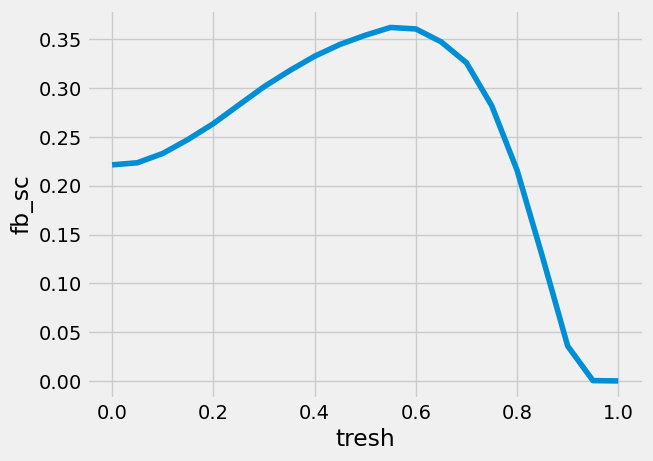

In [51]:
import seaborn as sns
sns.lineplot(data=df_tresh, x="tresh", y="fb_sc")

best treshold : 0.55

In [52]:
def get_performances(X_tr, y_tr, X_te, y_te, model, treshold):
    
    y_tr_prob = model.predict_proba(X_tr)[:,1]
    y_te_prob = model.predict_proba(X_te)[:,1]

    auc_tr = roc_auc_score(y_tr, y_tr_prob)
    auc_te = roc_auc_score(y_te, y_te_prob)
    
    y_tr_pred = (y_tr_prob > treshold).real
    y_te_pred = (y_te_prob > treshold).real

    pre_tr = precision_score(y_tr, y_tr_pred)
    pre_te = precision_score(y_te, y_te_pred)

    rec_tr = recall_score(y_tr, y_tr_pred)
    rec_te = recall_score(y_te, y_te_pred)

    f1_tr = f1_score(y_tr, y_tr_pred)
    f1_te = f1_score(y_te, y_te_pred)
    
    fbeta_tr = fbeta_score(y_tr, y_tr_pred, beta=1.5)
    fbeta_te = fbeta_score(y_te, y_te_pred, beta=1.5)


    perf_metrics = {
        'pre_tr': pre_tr,
        'pre_te': pre_te,
        'rec_tr': rec_tr,
        'rec_te': rec_te,
        'f1_tr': f1_tr,
        'f1_te': f1_te,
        'auc_tr': auc_tr,
        'auc_te': auc_te,
        'fbeta_tr': fbeta_tr,
        'fbeta_te': fbeta_te
    }

    return perf_metrics

In [53]:
from mlflow.models.signature import infer_signature

# Setting an experiment for automatic logging
mlflow.set_experiment(experiment_name="ML_with_classweight_feat_eng_fbeta_best_model_tresh")

# Checking if the script is executed directly
if __name__ == "__main__":

    with mlflow.start_run(run_name="LGBMClassifier") as run:
        # Fitting GridSearchCV
        model = clf2
        clf2.fit(X_train, y=y_train)
        #signature = infer_signature(X_train, model.predict_proba(X_train))
        mlflow.log_params(clf2.best_params_)
        perf_metrics = get_performances(X_train, y_train, X_test, y_test, model, treshold=0.55)
        mlflow.log_metrics(perf_metrics)
              

2023/05/05 14:56:22 INFO mlflow.tracking.fluent: Experiment with name 'ML_with_classweight_feat_eng_fbeta_best_model_tresh' does not exist. Creating a new experiment.


In [92]:
X = scaler.transform(X)

In [93]:
y_prob = clf2.predict_proba(X)[:,1] #regarder proba
y_pred = (y_prob > 0.55).real

In [96]:
y_pred

array([ True, False, False, ..., False, False, False])

In [54]:
from mlflow.models.signature import infer_signature

# Setting an experiment for automatic logging
mlflow.set_experiment(experiment_name="ML_with_classweight_feat_eng_fbeta_best_model_tresh_savemodel")

# Checking if the script is executed directly
if __name__ == "__main__":

    with mlflow.start_run(run_name="LGBMClassifier") as run:
        # Fitting GridSearchCV
        model = clf2
        clf2.fit(X_train, y=y_train)
        #signature = infer_signature(X_train, model.predict_proba(X_train))
        mlflow.log_params(clf2.best_params_)
        perf_metrics = get_performances(X_train, y_train, X_test, y_test, model, treshold=0.55)
        mlflow.log_metrics(perf_metrics)
        mlflow.sklearn.log_model(model, "model")
        modelpath = "/dbfs/mlflow/scoring_bancaire/model" 
        mlflow.sklearn.save_model(model, modelpath) 
        
        
        
        

2023/05/05 16:04:23 INFO mlflow.tracking.fluent: Experiment with name 'ML_with_classweight_feat_eng_fbeta_best_model_tresh_savemodel' does not exist. Creating a new experiment.


OSError: [Errno 30] Read-only file system: '/dbfs'

In [57]:
artifact_path = "model"

with mlflow.start_run(run_name="LGBMClassifier") as run:
        # Fitting GridSearchCV
        #model = clf2
        #clf2.fit(X_train, y=y_train)
        #signature = infer_signature(X_train, model.predict_proba(X_train))
        #mlflow.log_params(clf2.best_params_)
        #perf_metrics = get_performances(X_train, y_train, X_test, y_test, model, treshold=0.55)
        #mlflow.log_metrics(perf_metrics)
        
        model_info = mlflow.lightgbm.log_model(model, artifact_path)
        
        #mlflow.sklearn.log_model(model, "model")
        #modelpath = "/dbfs/mlflow/scoring_bancaire/model" 
        #mlflow.sklearn.save_model(model, modelpath) 

In [55]:
artifact_path = "model"

with mlflow.start_run():
    model_info = mlflow.lightgbm.log_model(model, artifact_path)

In [ ]:
with mlflow.start_run(run_name="YOUR_RUN_NAME") as run:
    params = {"n_estimators": 5, "random_state": 42}
    sk_learn_rfr = RandomForestRegressor(**params)

    # Log parameters and metrics using the MLflow APIs
    mlflow.log_params(params)
    mlflow.log_param("param_1", randint(0, 100))
    mlflow.log_metrics({"metric_1": random(), "metric_2": random() + 1})

    # Log the sklearn model and register as version 1
    mlflow.sklearn.log_model(
        sk_model=sk_learn_rfr,
        artifact_path="sklearn-model",
        registered_model_name="sk-learn-random-forest-reg-model",
    )

In [58]:
result = mlflow.register_model(
    "runs:/474c6d6cc4464dd8a0bfa2129d7d247c/model", "test"
)

Registered model 'test' already exists. Creating a new version of this model...
2023/05/05 18:33:56 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: test, version 1
Created version '1' of model 'test'.


In [59]:
logged_model = 'runs:/474c6d6cc4464dd8a0bfa2129d7d247c/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)



In [61]:
type(loaded_model)

mlflow.pyfunc.PyFuncModel

# Interpretation globale - Feature importance

In [342]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

In [336]:
best_estimator = clf2.best_estimator_

In [337]:
best_estimator

LGBMClassifier(class_weight='balanced', learning_rate=0.2, reg_alpha=0.03)

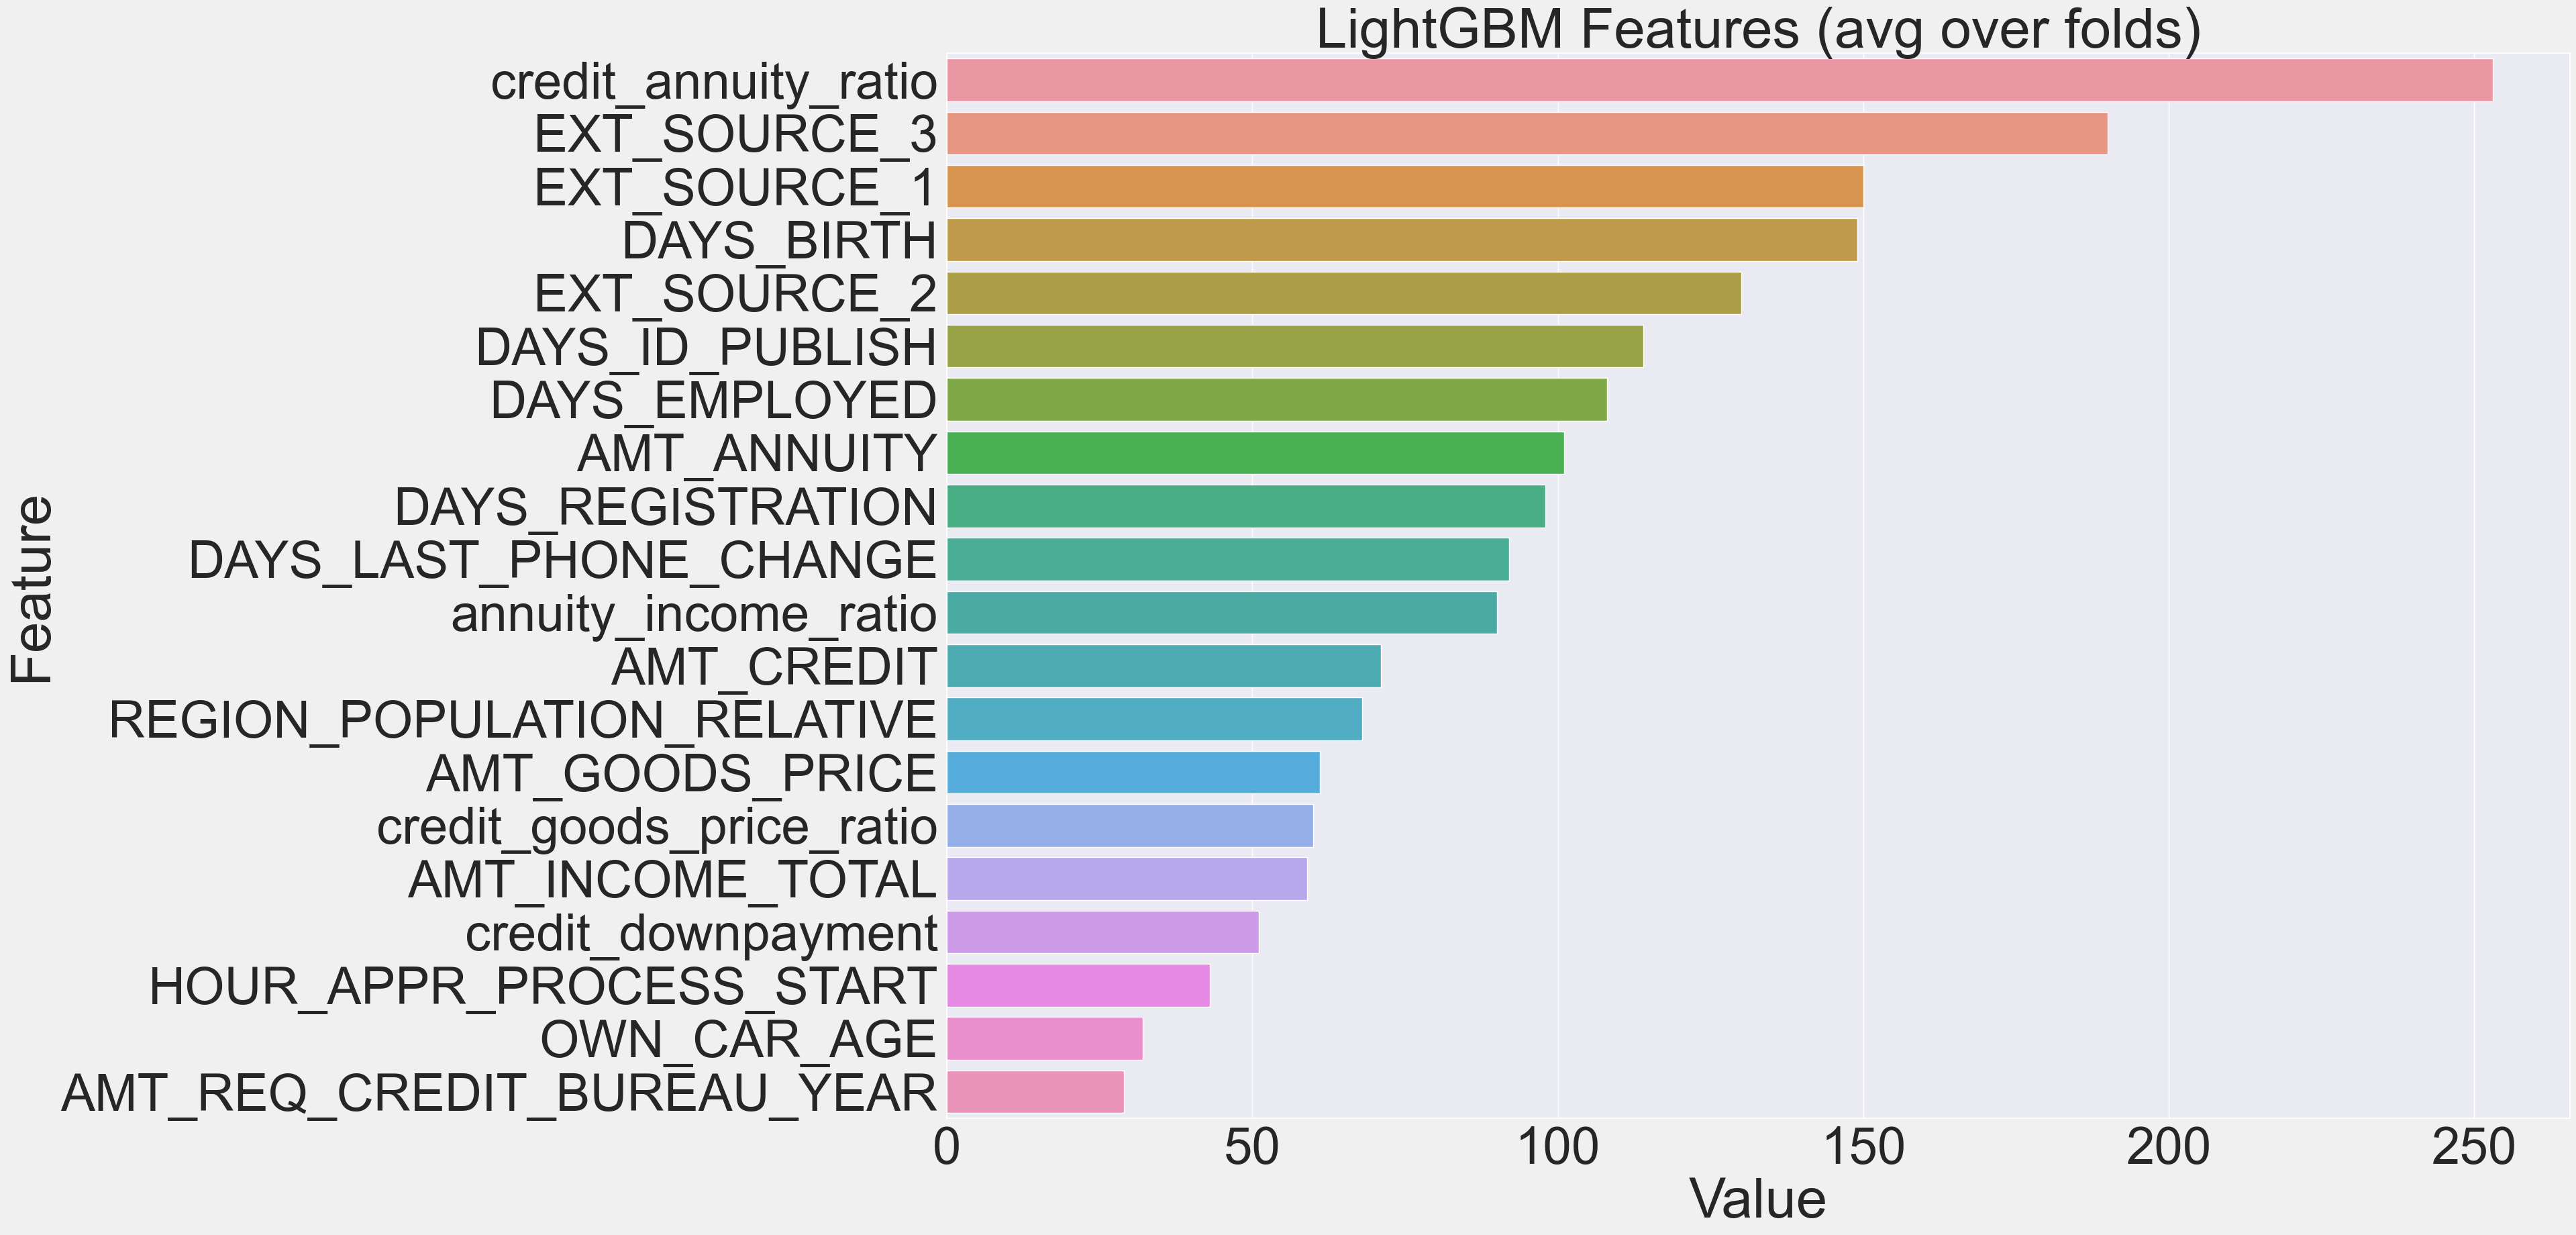

In [343]:
plotImp(best_estimator, X)

# Interpretation locale - force plot / summary plot

In [344]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [345]:
explainer = shap.TreeExplainer(best_estimator)
shap_values = explainer.shap_values(X)

In [348]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X.columns)

In [354]:
shap_values[:2]

[array([[-2.45540528e-02, -5.61654109e-02,  4.81865304e-04, ...,
         -1.72732196e-01,  2.43405834e-01,  0.00000000e+00],
        [-3.48405062e-02, -1.53434014e-01, -5.25011636e-05, ...,
         -6.48763965e-02,  1.95985492e-01,  0.00000000e+00],
        [ 3.19559137e-01,  1.93263374e-01, -3.44917242e-06, ...,
         -7.68869630e-02,  9.76374690e-02,  0.00000000e+00],
        ...,
        [-2.45513709e-02, -1.27129295e-01,  3.07239371e-04, ...,
         -2.22614917e-01,  7.29631347e-02,  0.00000000e+00],
        [-2.74510456e-02, -1.56446068e-01,  4.95419425e-04, ...,
         -7.72288549e-02,  8.26306656e-02,  0.00000000e+00],
        [-1.95883664e-02, -9.42342426e-02, -9.17587600e-04, ...,
         -5.29228171e-02,  1.51247837e-01,  0.00000000e+00]]),
 array([[ 2.45540528e-02,  5.61654109e-02, -4.81865304e-04, ...,
          1.72732196e-01, -2.43405834e-01,  0.00000000e+00],
        [ 3.48405062e-02,  1.53434014e-01,  5.25011636e-05, ...,
          6.48763965e-02, -1.95985492e

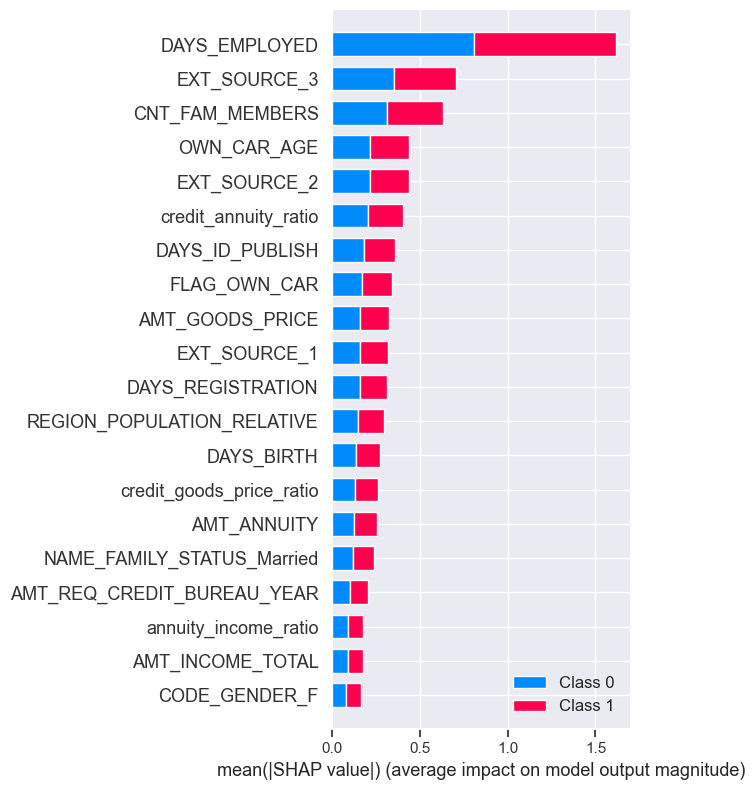

In [355]:
shap.summary_plot(shap_values[:20], X[:20])